#### Inicialização de variáveis e importação de bibliotecas

In [19]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.models import Sequential
from keras import layers, Input
from keras.preprocessing.image import load_img, img_to_array


AUTOTUNE = tf.data.AUTOTUNE

batch_size = 32
img_height = 180
img_width = 180
data_dir='data/cuted/'

#### Definição dos diretórios de treinamento e validação
    



O primeiro conjunto de dados, ```train_ds```, é para treinamento. Lendo imagens do diretório especificado em data_dir, dividindo 20% dos dados para validação (deixando 80% para treinamento) com a opção ```validation_split=0.2```, e especificando que este é o conjunto de "treinamento" com ```subset="training"```. Você também está definindo uma semente para a divisão dos dados com ```seed=123```, redimensionando todas as imagens para o tamanho especificado em ```(img_height, img_width)```, e definindo o tamanho do lote com ```batch_size```.

O segundo conjunto de dados, val_ds, é para validação. As opções são as mesmas, exceto que subset é definido como "validation", indicando que este conjunto de dados deve ser a parte de validação da divisão.

In [20]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1613 files belonging to 2 classes.
Using 1291 files for training.


Found 1613 files belonging to 2 classes.
Using 322 files for validation.


In [21]:
class_names = train_ds.class_names
print(class_names)

['header-test', 'non-header']


#### Plotagem de imagens de treinamento e suas classes



Criação de gráfico de 3x3 que mostra 9 imagens de treinamento e suas classes correspondentes. Usando o conjunto de dados de treinamento, train_ds, e iterando sobre ele para obter um lote de imagens e rótulos. Permitindo a plotagem das imagens e rótulos correspondentes.

2024-04-09 23:23:44.612738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


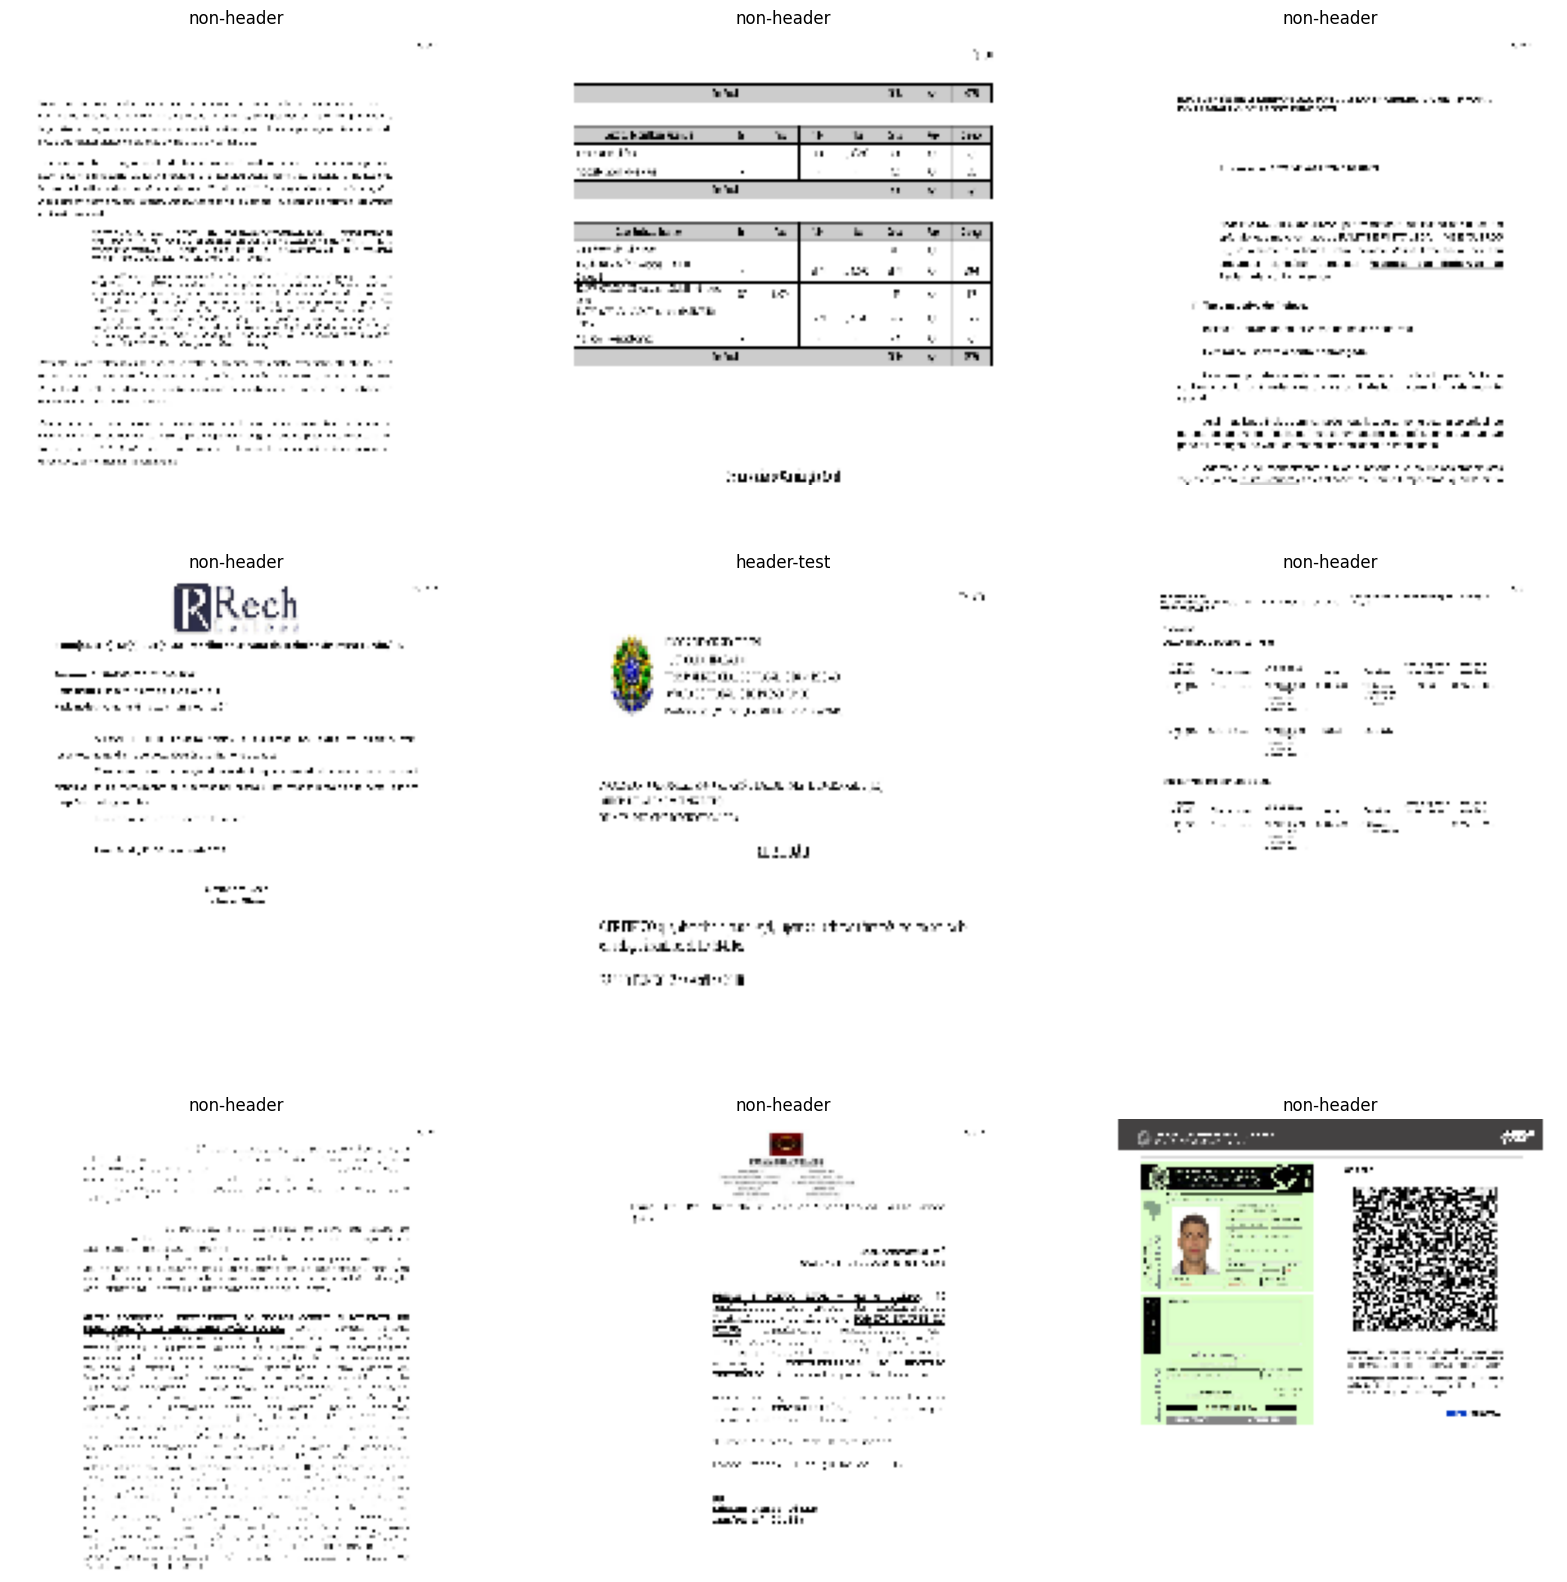

In [22]:
import matplotlib.pyplot as plt
i=0
plt.figure(figsize=(20, 20))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#### Otimização de desempenho dos conjuntos de dados


```.cache()```: mantém os dados na memória depois de serem carregados do disco. Isso garante que o conjunto de dados não precisa ser recarregado a cada época, melhorando o desempenho.  

```.shuffle(1000)```: randomiza a ordem dos exemplos no conjunto de dados de treinamento. Isso é importante para evitar que o modelo aprenda dependências indesejadas da ordem dos exemplos.  

```.prefetch(buffer_size=AUTOTUNE)``` antecipa o carregamento dos dados para a próxima época enquanto o modelo está treinando na época atual. Isso melhora o desempenho ao reduzir o tempo de inatividade entre as épocas. AUTOTUNE permite que o TensorFlow escolha automaticamente o número de lotes para antecipar.  


Para o conjunto de dados de validação, apenas ```.cache()``` e ```.prefetch(buffer_size=AUTOTUNE)``` são usados, pois não é necessário embaralhar os exemplos.

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Padronização dos dados



Normalização dos valores de pixel das imagens para que estejam no intervalo de [0, 1]. Isso é feito dividindo cada valor de pixel por 255, pois um canal RGB tem valores de pixel no intervalo [0, 255].

In [24]:
normalization_layer = keras.layers.Rescaling(1./255)

#### Definição do Modelo



```num_classes = len(class_names)```: Define o número de classes que o modelo precisa prever. Isso é baseado no número de nomes de classes fornecidos.

```model = Sequential()```: Inicia a definição de um novo modelo sequencial. Modelos sequenciais são uma pilha linear de camadas.

```Input(shape=(img_height, img_width, 3))```: Define a forma da entrada para o modelo. Neste caso, a entrada é uma imagem colorida (3 canais para vermelho, verde e azul) com altura e largura especificadas.

```layers.Rescaling(1./255)```: Reescala os valores de pixel da imagem para o intervalo [0,1].

```layers.Conv2D(16, 3, padding='same', activation='relu')```: Adiciona uma camada convolucional 2D com 16 filtros, um tamanho de kernel de 3 e ativação ReLU.

```layers.MaxPooling2D()```: Adiciona uma camada de pooling para reduzir a dimensionalidade espacial.

As próximas duas camadas Conv2D e MaxPooling2D são semelhantes à 5ª e 6ª linha, mas com mais filtros na camada convolucional.

```layers.Flatten()```: Achata a saída da última camada de pooling para um vetor unidimensional.

```layers.Dense(128, activation='relu')```: Adiciona uma camada densamente conectada com 128 neurônios e ativação ReLU.

```layers.Dense(num_classes)```: Adiciona uma camada densa final com um número de neurônios igual ao número de classes. Esta camada produz a saída do modelo.

In [25]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/home/daviga/projects/machine-learning/.venv/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 160, 160, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 80, 80, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 80, 80, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,300,770 (12.59 MB)

 Trainable params: 3,300,770 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
epochs=60
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 0.5747 - loss: 1.2865 - val_accuracy: 0.8882 - val_loss: 0.2944
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.9200 - loss: 0.2403 - val_accuracy: 0.9224 - val_loss: 0.1898
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.9495 - loss: 0.1578 - val_accuracy: 0.9379 - val_loss: 0.1967
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.9759 - loss: 0.1127 - val_accuracy: 0.9534 - val_loss: 0.1290
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.9839 - loss: 0.0479 - val_accuracy: 0.9627 - val_loss: 0.1165
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.9911 - loss: 0.0449 - val_accuracy: 0.9503 - val_loss: 0.1495
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.9891 - loss: 0.0393 - val_accuracy: 0.9658 - val_loss: 0.1294
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9972 - loss: 0.0116 - val_accuracy: 0.9689 -

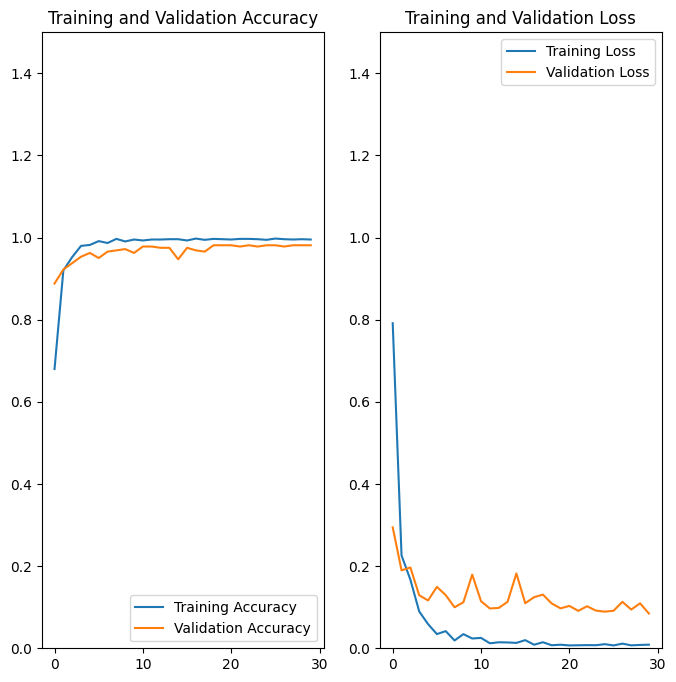

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylim([0, 1.5]) 

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim([0, 1.5])
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


2024-04-09 23:26:01.718323: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


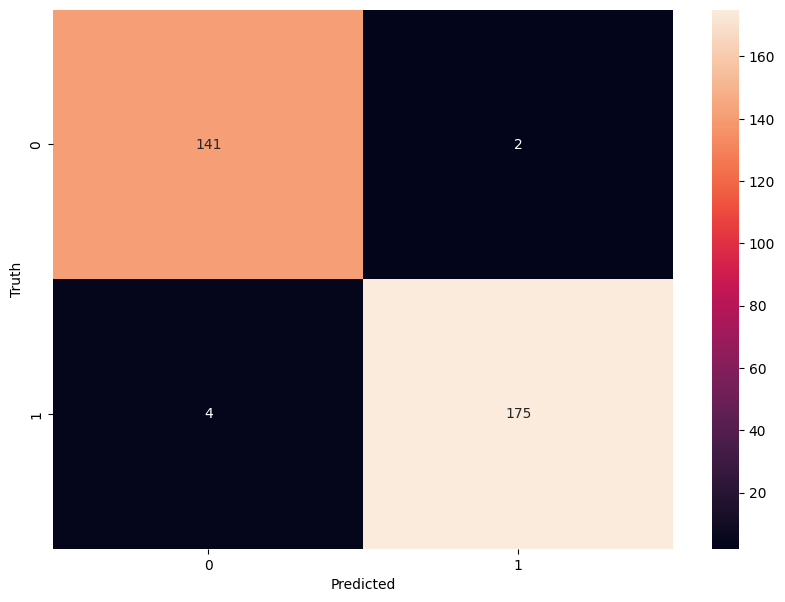

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Suponha que você tenha um modelo treinado chamado 'model'
# E você usa o conjunto de validação para fazer previsões
y_pred = model.predict(val_ds)

# Converta as previsões em rótulos de classe
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtenha os rótulos verdadeiros do conjunto de validação
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Calcule a matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)

# Visualize a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [30]:
import os

# Ensure the model is loaded and compiled
# model = tf.keras.models.load_model('path_to_your_model.h5')

# Get a list of all .png files in the 'predict' directory
prediction_files = [f for f in os.listdir('data/predict') if f.endswith('.png')]

for prediction_file in prediction_files:
    prediction_path = os.path.join('data/predict', prediction_file)
    
    # Load the image
    img = load_img(prediction_path, target_size=(img_height, img_width))

    # Convert the image to an array and normalize it
    img_array = img_to_array(img)
    img_array = img_array / 255.0

    # Expand the dimensions of the image
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "The image {} most likely belongs to {} with a {:.2f} percent confidence."
        .format(prediction_file, class_names[np.argmax(score)], 100 * np.max(score))
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
The image page_2300_p7.png most likely belongs to non-header with a 98.73 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
The image page_2533_p7.png most likely belongs to non-header with a 98.70 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
The image page_2315_p7.png most likely belongs to non-header with a 98.71 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
The image page_915_p7.png most likely belongs to non-header with a 98.75 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
The image page_1553_p7.png most likely belongs to non-header with a 98.73 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
The image page_132_p7.png most likely belongs to non-header with a 98.71 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
The image page_314_p7.png most likely belongs to non-header with a 98.74 percent confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
The image page_2838_p7.png most likely be

KeyboardInterrupt: 